# Load Measurement Data (Time Series)

In this example Notebook, we show you how to load time series (channel) data from your Peak ODS Server.

The first sections are on initializing and connecting. The fun starts with "Load Measurement".

## Dependencies for this notebook

The [ASAM ODSBox](https://pypi.org/project/odsbox/) contain some functionality that wraps the ODS HTTP API making using Python easier  ;-)

It contains:
- http wrapper implemented using protobuf and requests
- utility that converts ODS DataMatrices into pandas.DataFrame

In [5]:
try:  
  import odsbox
except:
  !pip install odsbox 

from odsbox.con_i import ConI
from odsbox.submatrix_to_pandas import submatrix_to_pandas

## Connect to ASAM ODS server

The ODS HTTP API is a session based API. The session ID is called conI in the ODS documentation. The [ASAM ODSBox](https://pypi.org/project/odsbox/) uses con_i as API object representing the session. Close this session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

In [6]:
conI = ConI(url='http://79.140.180.128:10032/api', auth=('Demo','mdm'))

## Load Measurement 

### Query for available measurement data
Measurement (or time series) data is contained in a structure called 'Submatrix' containing the individual channels (columns) of the measurement.
In the example below the first 10 submatrices of some MDF4 files (see query pattern) are requested from the server.
Let's pick the first submatrix of that list for further data exploration.

In [7]:
sms = conI.query_data({
#    "SubMatrix": {"measurement.test.Name": {"$like": "Profile*.mf4"}},
    "SubMatrix": {"measurement.Name": {"$like": "Profile*"}},
    "$attributes": {
        "Name": 1,
        "Id": 1
    },
    "$options": {"$rowlimit": 10}
})

print(sms)

# just pick the first one
submatrix_id = sms["SubMatrix.Id"].iloc[0]
print("Submatrix id: " + str(submatrix_id))

  SubMatrix.Name  SubMatrix.Id
0     Profile_52           282
1     Profile_06           330
2     Profile_14           319
3     Profile_80           308
4     Profile_71           277
5     Profile_64           296
6     Profile_45           301
7     Profile_53           311
8     Profile_56           297
9     Profile_42           287
Submatrix id: 282


### Load measurement data and convert to DataFrame
From our imported library we use 'submatrix_to_dataframe' to get a pandas.DataFrame from that submatrix we've selected above...

In [8]:
df = submatrix_to_pandas(conI, submatrix_id)

if "Time" in df.columns:
    df.set_index("Time", inplace=True)
elif "time" in df.columns:
    df.set_index("time", inplace=True)

df.head()

U_q    Coolant  Stator_winding        U_d  Stator_tooth  \
Time                                                                  
0.0   -1.870446  78.804928       53.393323   0.627027     55.588612   
0.5    3.747699  78.859141       53.460695  -2.550798     55.659321   
1.0   13.771337  78.900886       53.480459  -9.704846     55.698835   
1.5   26.851160  78.939788       53.451930 -19.583736     55.723997   
2.0   42.088467  78.966302       53.467553 -31.885562     55.743452   

      Motor_speed        I_d        I_q         Pm  Stator_yoke    Ambient  \
Time                                                                         
0.0      2.761764  -2.001388   1.094317  49.695740    60.426506  25.321585   
0.5    102.164216  -6.588812  21.266870  49.689940    60.490822  25.308411   
1.0    314.802839 -11.969288  41.992287  49.675229    60.542482  25.295898   
1.5    608.984106 -16.067978  57.526612  49.686365    60.578285  25.275402   
2.0    961.552082 -19.428698  69.952405  49.692206    60.605028  25.263575   

            Torque  
Time                
0.0   3.138413e-13  
0.5   1.465798e+01  
1.0   2.993536e+01  
1.5   4.141312e+01  
2.0   5.064337e+01

### Working with the DataFrame
Now that the data is in a DataFrame, you can use all operations supported on DataFrames.
So let's dump the content of the DataFrame:

In [9]:
df.describe()

U_q      Coolant  Stator_winding          U_d  Stator_tooth  \
count  3726.000000  3726.000000     3726.000000  3726.000000   3726.000000   
mean     67.858769    44.695021       84.599968   -18.567216     72.656560   
std      38.303788    29.715035       24.038284    68.659465     20.899099   
min      -1.870446    21.892367       53.393323  -130.287115     49.406596   
25%      34.314099    23.865233       62.909840   -69.432621     53.301582   
50%      63.728396    24.331117       77.509271   -28.315255     63.334331   
75%     104.456075    87.694295      105.292420    42.223311     94.827537   
max     131.007577    93.044237      129.505462   129.192577    109.745895   

       Motor_speed          I_d          I_q           Pm  Stator_yoke  \
count  3726.000000  3726.000000  3726.000000  3726.000000  3726.000000   
mean   2664.812358   -82.763015    25.978936    68.360572    61.577348   
std    1582.960313    53.083745   126.220274     5.527616    21.848725   
min       2.761764  -220.065137  -286.302859    49.456254    39.452287   
25%    1285.600032  -119.317662   -51.186357    65.366317    42.742347   
50%    2275.865870   -83.930571    30.829907    69.307767    49.421987   
75%    4200.568607   -37.703737   109.148789    71.763340    82.485244   
max    5878.078608     0.006143   295.802479    78.217617    99.151240   

           Ambient       Torque  
count  3726.000000  3726.000000  
mean     26.270603    21.205737  
std       0.219805   104.113044  
min      25.258767  -240.357719  
25%      26.277492   -51.862707  
50%      26.364420    26.210855  
75%      26.382636    88.885470  
max      26.384509   245.538906

... and we can plot some curves (remember we set 'time' to be the index at the beginning) ...

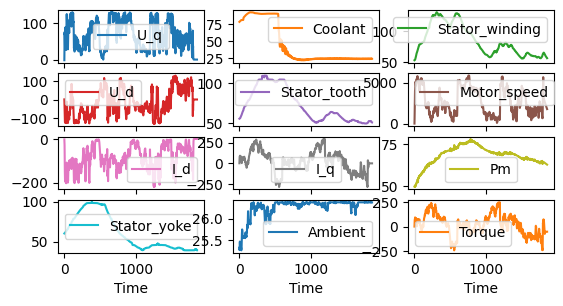

In [10]:
_ = df.plot(kind="line", subplots=True, layout=(6,3), sharex=True)

... or only one curve ...

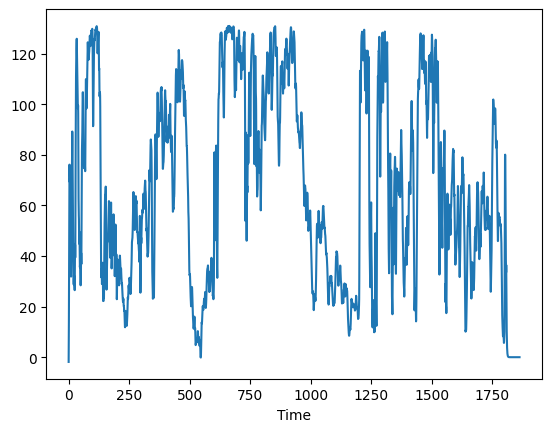

In [11]:
_ = df[df.columns[0]].plot(kind="line")

... or get some information of the index channel - time axis should be monotonic ;-)

In [12]:
df.index.is_monotonic_increasing

True

## Close Session
Don't forget to close the session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

In [13]:
conI.logout()

## License

Copyright © 2024 [Peak Solution GmbH](https://peak-solution.de)

The training material in this repository is licensed under a Creative Commons BY-NC-SA 4.0 license. See [LICENSE](../LICENSE) file for more information.